In [81]:
import numpy as np
import keras 
from keras import regularizers
from keras import backend as k
from keras.models import Sequential 
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
%matplotlib inline

#  Create model

In [82]:
train_path = 'hydro_dataset/train'
valid_path = 'hydro_dataset/valid'
test_path = 'hydro_dataset/test'

# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).

In [83]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(64,64), classes=['hairy_root', 'non_hairy_root'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(64,64), classes=['hairy_root', 'non_hairy_root'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(64,64), classes=['hairy_root', 'non_hairy_root'], batch_size=10)

Found 1200 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


# Plots images with lables within jupyter nothbook

In [84]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

(10, 64, 64, 3)


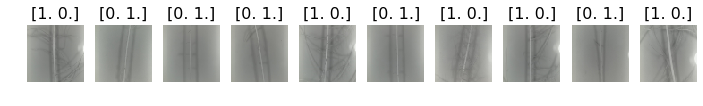

In [85]:
imgs, lables = next(train_batches)
plots(imgs, titles=lables)
print(imgs.shape)


# Building a fine-tuned VGG16 model

In [86]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(64, 64, 3), weights = 'imagenet')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

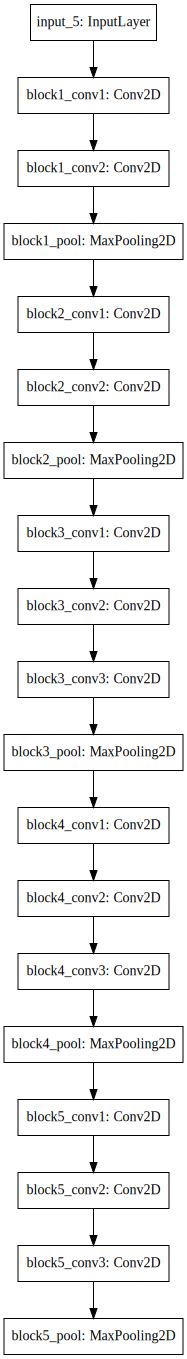

In [87]:
vgg16_model.summary()
SVG(model_to_dot(vgg16_model).create(prog='dot', format='svg'))

In [88]:
type(vgg16_model)

keras.engine.training.Model

# Convert model from "model" to sequential

In [89]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

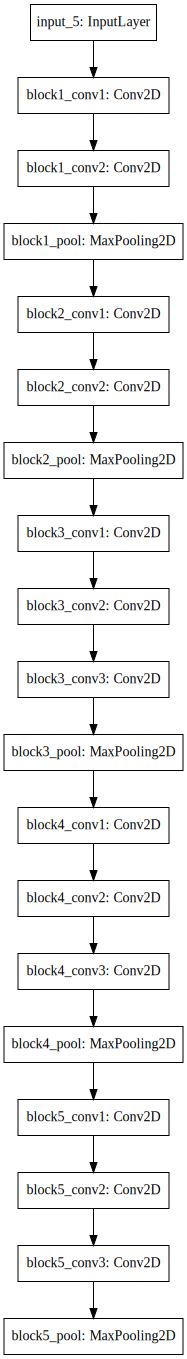

In [90]:
model.summary()
SVG(model_to_dot(vgg16_model).create(prog='dot', format='svg'))

# Freez further training 

In [91]:
for layer in model.layers:
    layer.trainable = False

In [92]:
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
print(imgs.shape)

(10, 64, 64, 3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

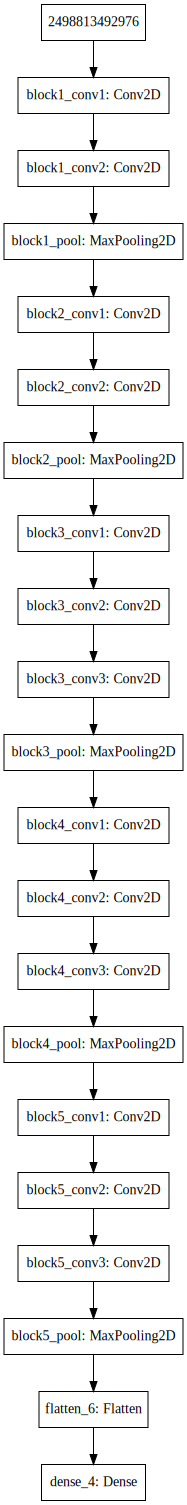

In [93]:
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Train the fine-tuned VGG16 model  - v14

In [94]:
model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=10, verbose=2)

Epoch 1/10
 - 2s - loss: 6.2326 - acc: 0.4250 - val_loss: 4.0574 - val_acc: 0.5750
Epoch 2/10
 - 1s - loss: 1.4633 - acc: 0.7500 - val_loss: 0.8138 - val_acc: 0.8000
Epoch 3/10
 - 1s - loss: 0.2323 - acc: 0.9000 - val_loss: 0.6176 - val_acc: 0.8750
Epoch 4/10
 - 2s - loss: 0.9156 - acc: 0.8000 - val_loss: 2.2507 - val_acc: 0.6500
Epoch 5/10
 - 2s - loss: 0.3154 - acc: 0.9500 - val_loss: 0.4155 - val_acc: 0.9500
Epoch 6/10
 - 1s - loss: 0.0957 - acc: 0.9250 - val_loss: 0.1669 - val_acc: 0.9062
Epoch 7/10
 - 1s - loss: 0.0534 - acc: 0.9500 - val_loss: 0.1698 - val_acc: 0.9750
Epoch 8/10
 - 2s - loss: 0.2115 - acc: 0.9750 - val_loss: 0.7912 - val_acc: 0.9250
Epoch 9/10
 - 1s - loss: 0.6433 - acc: 0.9250 - val_loss: 7.4672e-05 - val_acc: 1.0000
Epoch 10/10
 - 2s - loss: 0.3228 - acc: 0.9250 - val_loss: 0.0018 - val_acc: 1.0000


# Predict 

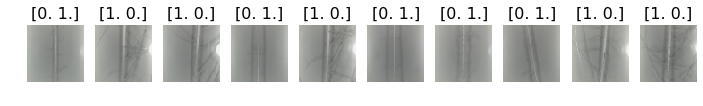

In [96]:
test_imgs, test_lables = next(test_batches)
plots(test_imgs, titles=test_lables)

In [97]:
test_lables = test_lables[:,0]
test_lables

array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1.], dtype=float32)

In [98]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [99]:
cm = confusion_matrix(test_lables, np.round(predictions[:,0]))

In [100]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0]
 [0 5]]


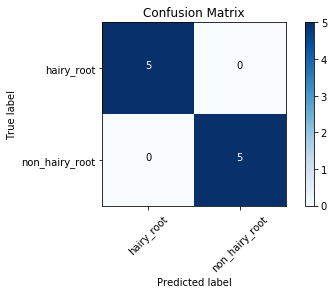

In [101]:
cm_plot_labls = ['hairy_root', 'non_hairy_root']
plot_confusion_matrix(cm, cm_plot_labls, title='Confusion Matrix')